# Linear Model

In [1]:
import xarray as xr
import numpy as np
from utils.funcs_linear import fit_plot_linear_model, plot_pcs, plot_waves, ERA5
import xarray as xr
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

from bluemath_tk.datamining.pca import PCA
from bluemath_tk.waves.estela import ESTELA, plot_defaults


## Generate dynamic predictor

### Load MSLP fields and generate predictor

In [2]:
variables = ["msl", "msl_gradient"]

In [3]:
p_msl_file = "/home/grupos/geocean/cagigall/geocean/DATA/hidronas1/volume3/Laura/DATA/ERA5/global_msl_1day_1degree_32bits.nc"

In [4]:
region = (-28+360, 15, 30, 50)

ob_era5 = ERA5(p_msl_file)
era5 = ob_era5.load_msl_data(coarsen = 2, area = region, compute_gradient = True)

Saved: data/era5_coars_2_332_15_30_50.nc


## PCA :  Principal Component Analysis

In [5]:
pca = PCA(n_components=0.95)

pca.fit_transform(
    data=era5,
    vars_to_stack=["msl", "msl_gradient"],
    coords_to_stack=["latitude", "longitude"],
    pca_dim_for_rows="time",
    value_to_replace_nans={"msl": 101325.0, "msl_gradient": 0.0},
)


        -------------------------------------------------------------------
        | Initializing PCA reduction model with the following parameters:
        |    - n_components: 0.95
        |    - is_incremental: False
        | For more information, please refer to the documentation.
        -------------------------------------------------------------------
        


2025-03-29 12:53:57,925 - PCA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.


<xarray.Dataset> Size: 4MB
Dimensions:      (time: 30642, n_component: 29)
Coordinates:
  * time         (time) datetime64[s] 245kB 1940-01-01 1940-01-02 ... 2023-11-22
  * n_component  (n_component) int64 232B 0 1 2 3 4 5 6 ... 22 23 24 25 26 27 28
Data variables:
    PCs          (time, n_component) float32 4MB -17.9 -15.81 ... 1.897 0.9207
    stds         (n_component) float32 116B 10.46 7.879 6.767 ... 1.042 0.9991

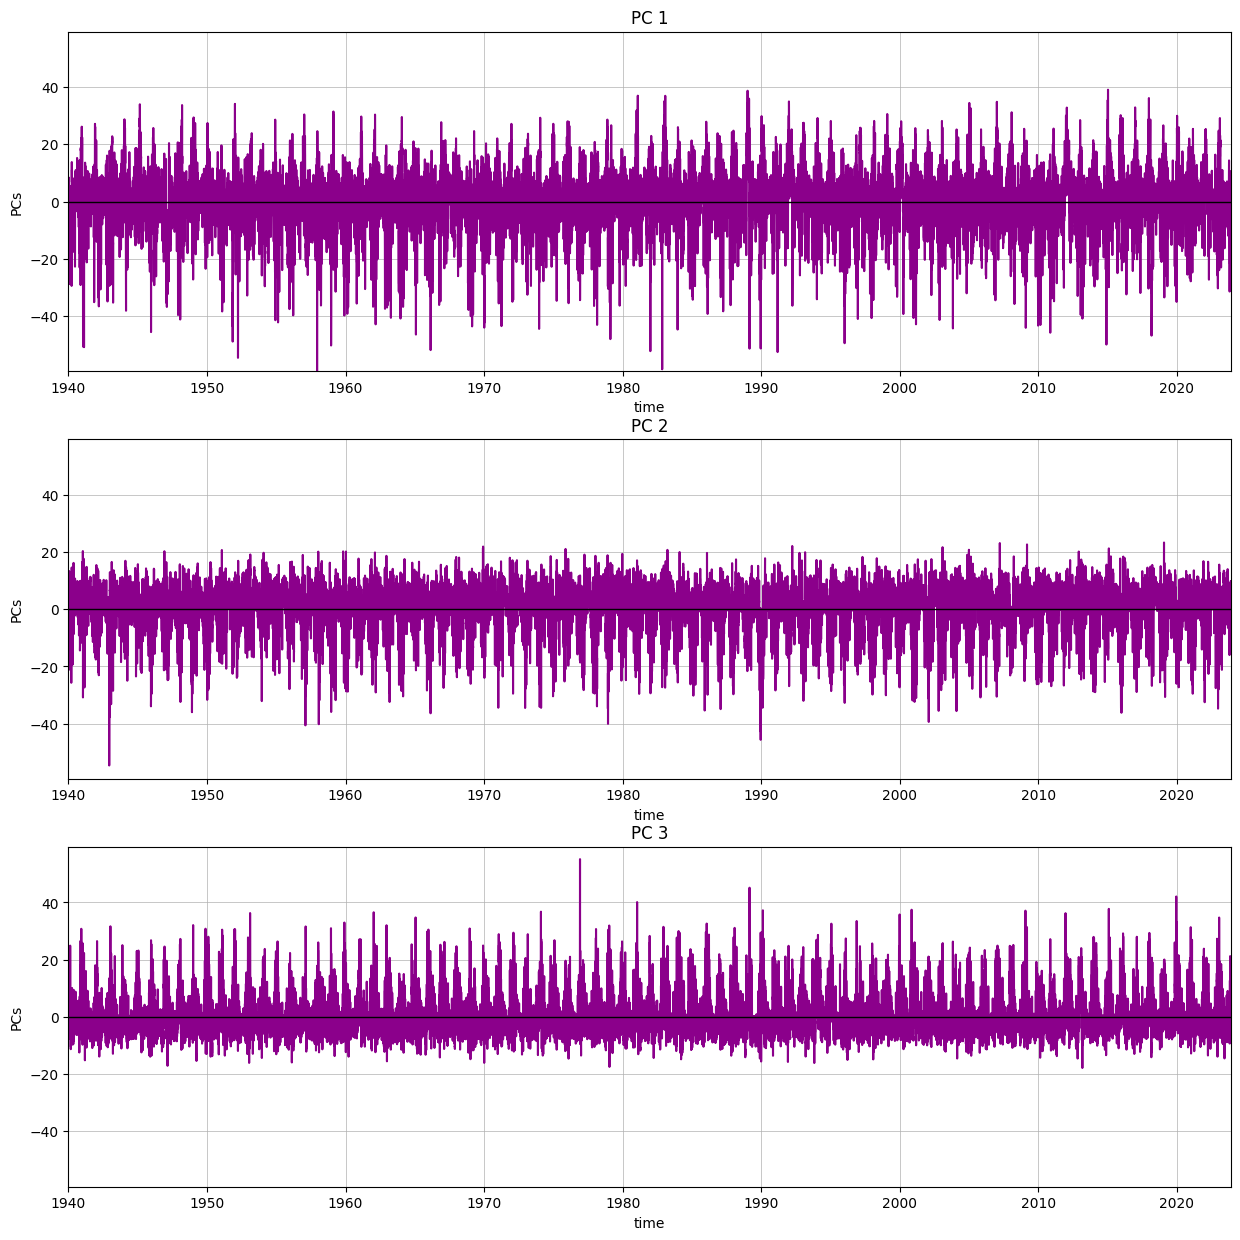

In [6]:
n_pcs = 3
plot_pcs(pca, n_pcs)

### Load Waves

In [7]:
if not os.path.exists("data/waves_EF_daily.nc"):

    waves = (
        xr.open_dataset("data/waves_era5.nc")[["swh", "pp1d"]].resample(time="1D").mean()
    )
    waves["EF"] = (waves["swh"] ** 2) * waves["pp1d"]
    waves = waves.drop("pp1d")
    waves.to_netcdf('data/waves_EF_daily.nc')
    
else:
    waves = xr.open_dataset("data/waves_EF_daily.nc")


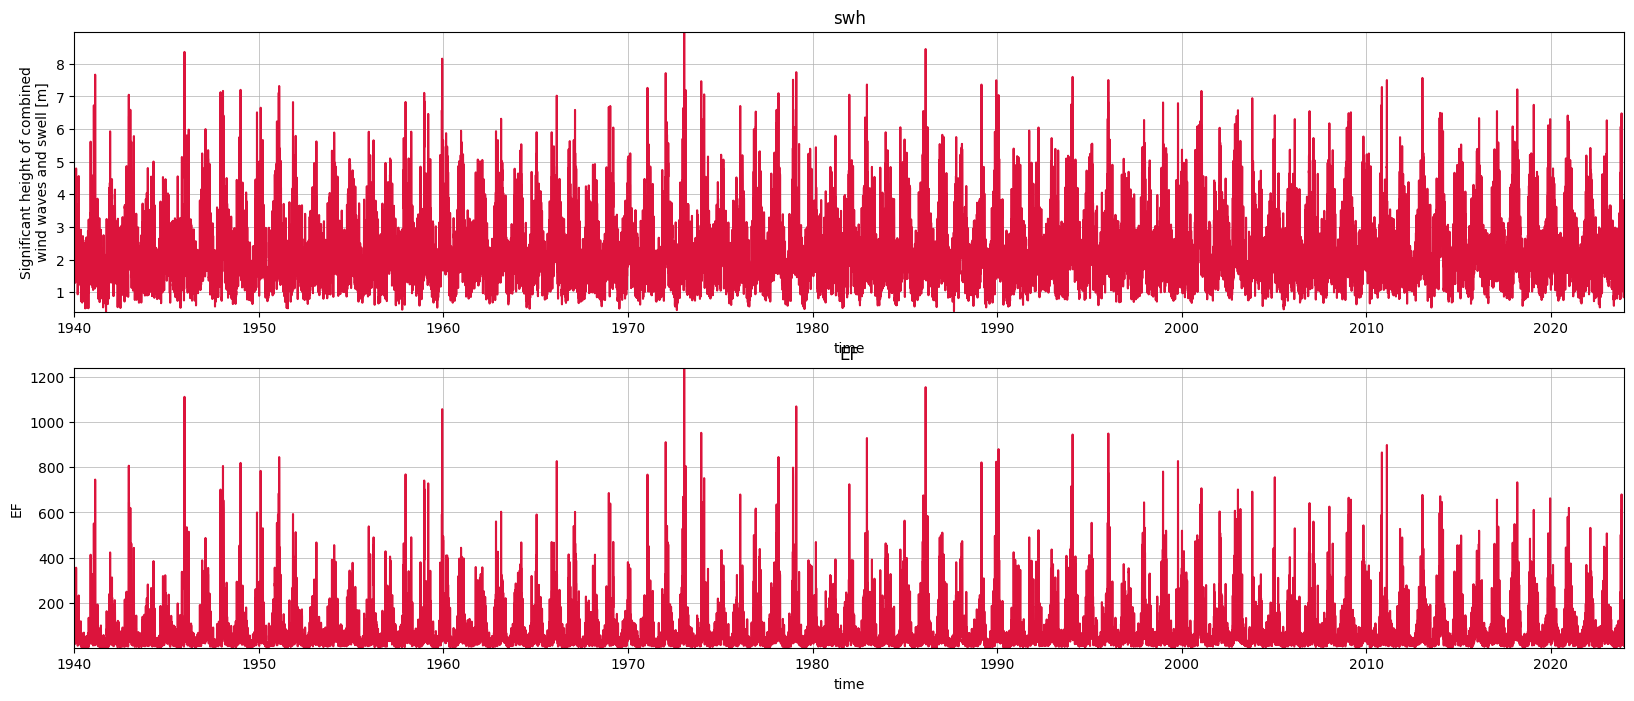

In [8]:
plot_waves(waves)

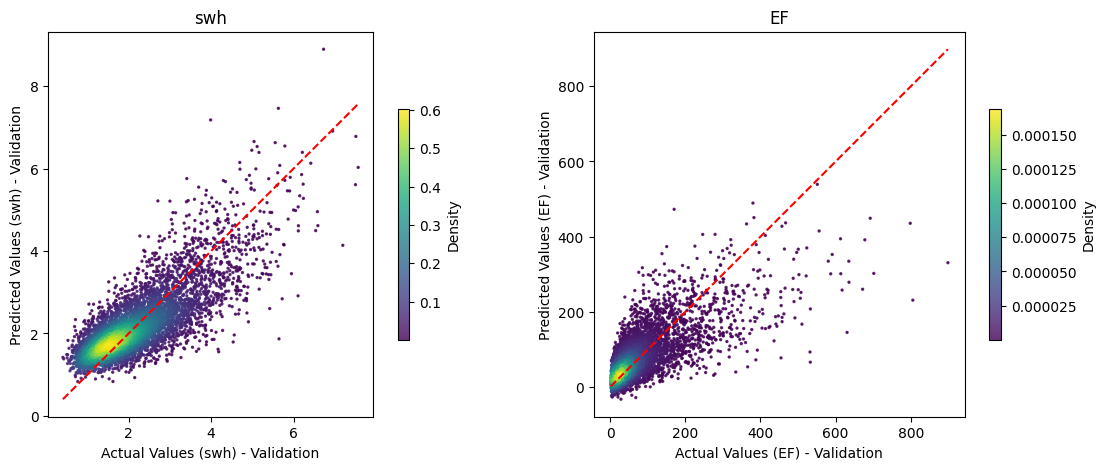

In [9]:
n_pcs = 20

common_times = np.intersect1d(pca.pcs.time, waves.time)

X = pca.pcs.sel(time=common_times).PCs.isel(n_component=range(n_pcs)).values
Ys = waves.sel(time=common_times).to_dataframe()[waves.data_vars.keys()].values

fit_plot_linear_model(X, Ys, keys = list(waves.data_vars.keys()), perc_train = 0.8)

## DYNAMIC PREDICTOR

### Load ESTELA for dynamic predictor

In [10]:
ob_est = ESTELA(p_waves=' ', save_monthly=True, only_sea=True)
ob_est.set_site(
    site="data", location=[-8.812405 + 360, 40.645615]
)  # define lon within [0-360]
ob_est.set_years(years=[1980, 2024])
ob_est.get_estela(
    do_estela=False
)  # If do_estela = False  it will only load the previously executed estela

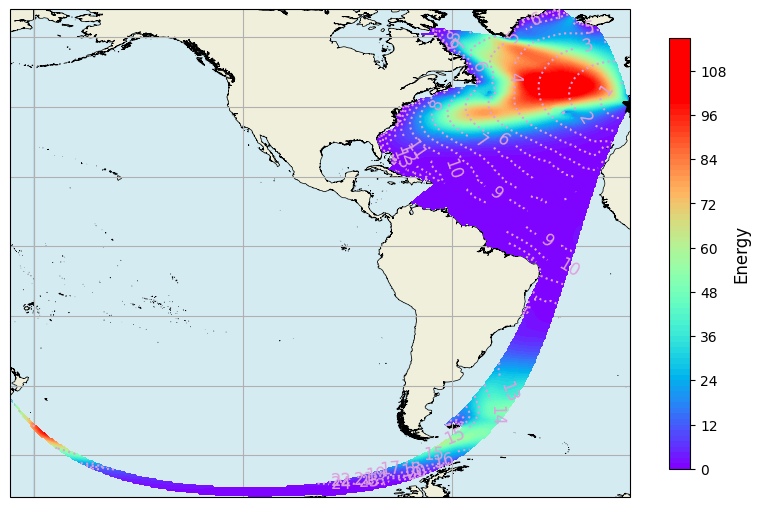

In [11]:
ob_est.plot_mean_estela(
    custom_params={"central_longitude": ob_est.lon0, "vmax": 100, "figsize": [10, 8]}
); 

In [12]:
ob_era5 = ERA5(p_msl_file)
era5 = ob_era5.load_msl_data(coarsen = 2, compute_gradient = True)
era5_dynamic = ob_era5.get_dynamic_estela_predictor(era5, estela = ob_est.estela)

Saved: data/era5_coars_2.nc
Saved: data/era5_dynamic.nc


## PCA :  Principal Component Analysis

In [15]:
pca_dynamic = PCA(n_components=0.95)

pca_dynamic.fit_transform(
    data=era5_dynamic,
    vars_to_stack=["msl", "msl_gradient"],
    coords_to_stack=["latitude", "longitude"],
    pca_dim_for_rows="time",
    value_to_replace_nans={"msl": 101325.0, "msl_gradient": 0.0},
)

2025-03-29 12:57:52,009 - PCA - WARNING - Changing variable OMP_NUM_THREADS from 1 to 1. 
And setting self.num_workers to 1. 
To avoid conflicts with BlueMath parallel processing.



        -------------------------------------------------------------------
        | Initializing PCA reduction model with the following parameters:
        |    - n_components: 0.95
        |    - is_incremental: False
        | For more information, please refer to the documentation.
        -------------------------------------------------------------------
        


2025-03-29 12:57:52,655 - PCA - WARNING - Data contains NaNs.
2025-03-29 12:57:53,402 - PCA - WARNING - Data contains NaNs.


<xarray.Dataset> Size: 38MB
Dimensions:      (time: 30642, n_component: 306)
Coordinates:
  * time         (time) datetime64[s] 245kB 1940-01-01 1940-01-02 ... 2023-11-22
  * n_component  (n_component) int64 2kB 0 1 2 3 4 5 ... 300 301 302 303 304 305
Data variables:
    PCs          (time, n_component) float32 38MB -2.142 -28.5 ... -0.5741
    stds         (n_component) float32 1kB 15.05 13.92 10.16 ... 0.7561 0.7552

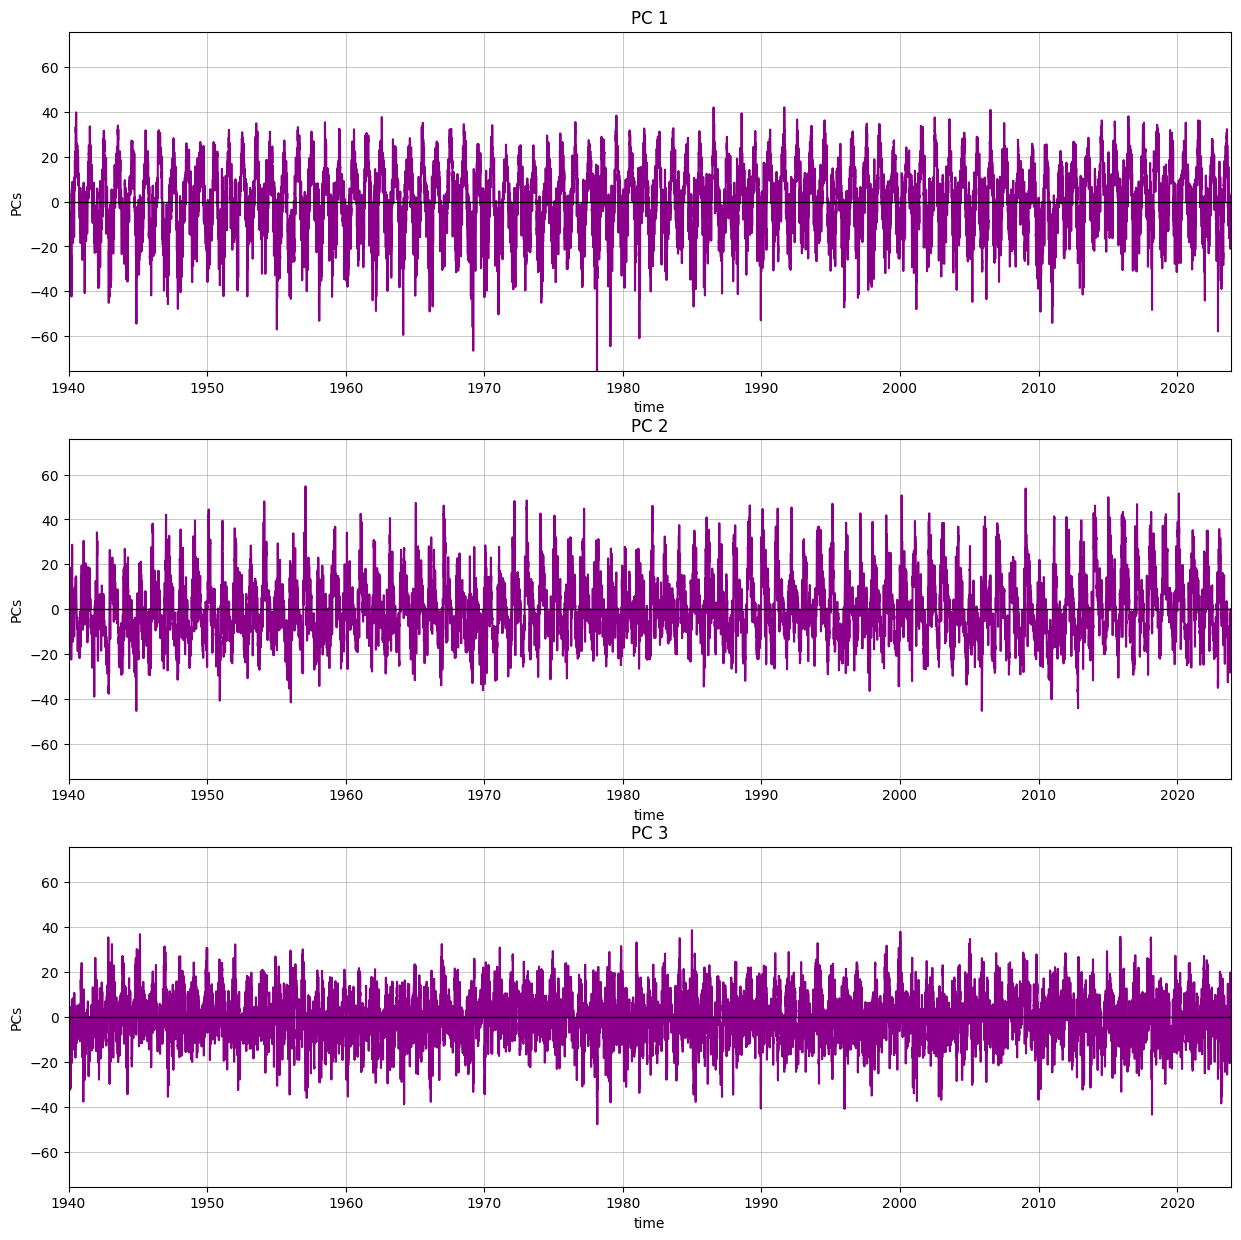

In [16]:
n_pcs = 3
plot_pcs(pca_dynamic, n_pcs)

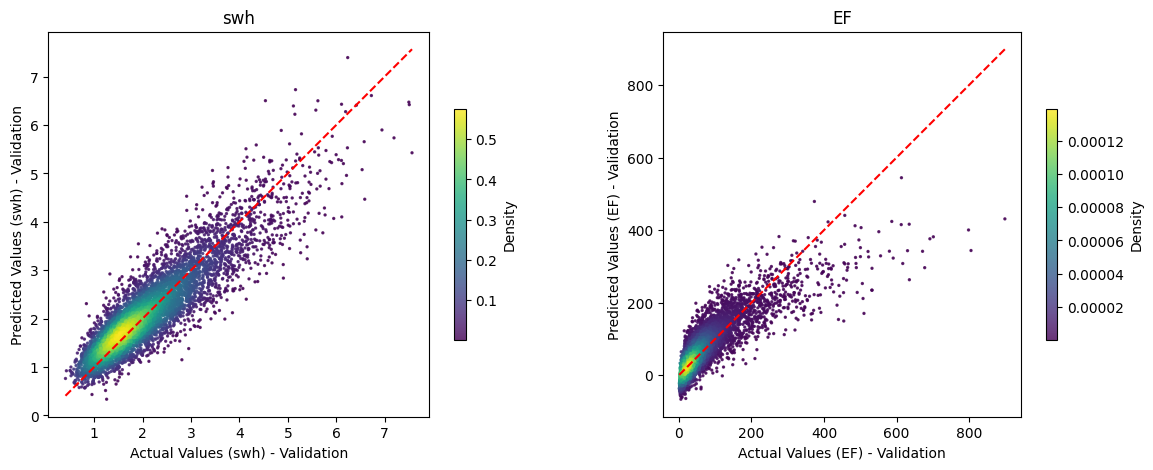

In [17]:
n_pcs = 300

common_times = np.intersect1d(pca_dynamic.pcs.time, waves.time)

X = pca_dynamic.pcs.sel(time=common_times).PCs.isel(n_component=range(n_pcs)).values
Ys = waves.sel(time=common_times).to_dataframe()[waves.data_vars.keys()].values

fit_plot_linear_model(X, Ys, keys = list(waves.data_vars.keys()), perc_train = 0.8)